In [34]:
# Decoding Errors
import numpy as np
import pandas as pd
import pandas as pd
from hipposlam.utils import read_pickle
from os.path import join
import os
import matplotlib.pyplot as plt
from pycircstat.descriptive import cdiff, mean as cmean

# Reinforcement learning performance

In [38]:
def load_moniter(project_dir, chpt_name, max_chpt_num):

    # Append traj data and fsigma
    allmonitorlist = []
    for i in range(1, max_chpt_num+1):
        monitor_pth = join(project_dir, chpt_name.replace('$', '%d'%i) + '.monitor.csv')
        monitor_df_each = pd.read_csv(monitor_pth, skiprows=[0])  # a list of dictionaries, each for one episode
        allmonitorlist.append(monitor_df_each)
    monitor_df = pd.concat(allmonitorlist, ignore_index=True)
    monitor_df['cuml'] = monitor_df['l'].cumsum()
    monitor_df

    return monitor_df



In [80]:
project_name = 'StateMapLearnerTaughtForest_R5L20_dp2_da8'
project_dir = join('data', project_name)
plot_dir = join('plots', project_name)
os.makedirs(plot_dir, exist_ok=True)
chpt_name = 'PPO$_UnSupervised'
max_chpt_num = 3
monitor_df_sup = load_moniter(project_dir, 'PPO$_FullySupervised', 8)
monitor_df_unsup = load_moniter(project_dir, 'PPO$_UnSupervised', 5)
monitor_df_perf = load_moniter(project_dir, 'PPO$_Perfect', 2)
monitor_df_rand = load_moniter(project_dir, 'PPO$_Random', 2)

In [72]:
load_hipposlam_pth = join(project_dir, chpt_name.replace('$', '%d'%max_chpt_num) + '_hipposlam.pickle')
hipposlam = read_pickle(load_hipposlam_pth)
hippoteach = hipposlam['hippoteach']

KeyError: 'hippoteach'

In [81]:
from scipy.ndimage import gaussian_filter1d

def get_stats(monitor_df):
    cuml = monitor_df['cuml']
    r = monitor_df['r']
    r_gau = gaussian_filter1d(r, sigma=20)

    done = monitor_df['terminated']*1.0
    # done = (monitor_df['r'] > 0.99) * 1.0
    done_gau = gaussian_filter1d(done, sigma=20)

    winmask = monitor_df['terminated'] == 1
    # winmask = monitor_df['r'] > 2
    windf = monitor_df[winmask]
    wincuml = windf['cuml']
    winl = windf['l']
    winl_gau = gaussian_filter1d(winl, sigma=5)

    return (cuml, r_gau, done_gau), (wincuml, winl, winl_gau)


def plot_winstats(ax, cuml, r_gau, done_gau, wincuml, winl, winl_gau, label):
    ax[0].plot(cuml, r_gau, label=label)
    ax[0].set_ylim(0, 2.5)
    ax[0].set_ylabel('Total R')
    ax[1].plot(cuml, done_gau, label=label)
    ax[1].set_ylim(-0.2, 1.0)
    ax[1].set_ylabel('Win rate')
    ax[2].scatter(wincuml, winl, marker='.', label=label)
    ax[2].plot(wincuml, winl_gau)
    ax[2].set_ylim(0, 360)
    ax[2].set_ylabel('Time steps to win')
    ax[2].set_xlabel('Cumulative time step of all episodes')
    for ac in ax:
        ac.legend()

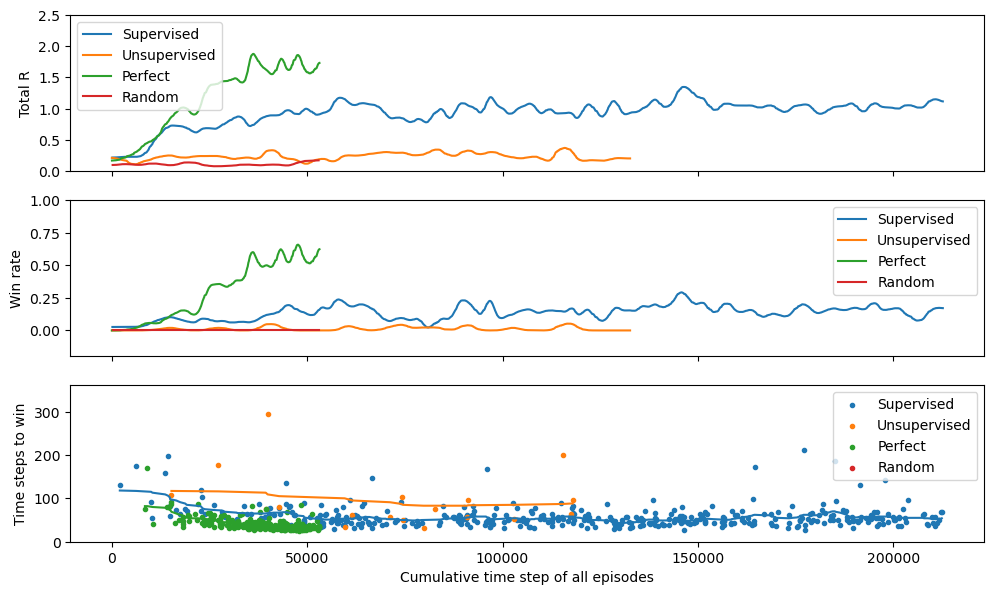

In [82]:
(cuml, r_gau, done_gau), (wincuml, winl, winl_gau) = get_stats(monitor_df_sup)
(cuml2, r_gau2, done_gau2), (wincuml2, winl2, winl_gau2) = get_stats(monitor_df_unsup)
(cuml3, r_gau3, done_gau3), (wincuml3, winl3, winl_gau3) = get_stats(monitor_df_perf)
(cuml4, r_gau4, done_gau4), (wincuml4, winl4, winl_gau4) = get_stats(monitor_df_rand)



fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
plot_winstats(ax, cuml, r_gau, done_gau, wincuml, winl, winl_gau, label='Supervised')
plot_winstats(ax, cuml2, r_gau2, done_gau2, wincuml2, winl2, winl_gau2, label='Unsupervised')
plot_winstats(ax, cuml3, r_gau3, done_gau3, wincuml3, winl3, winl_gau3, label='Perfect')
plot_winstats(ax, cuml4, r_gau4, done_gau4, wincuml4, winl4, winl_gau4, label='Random')
fig.tight_layout()
fig.savefig(join(plot_dir, f'{project_name}_WinStatistics.png'), dpi=300)

[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]
832


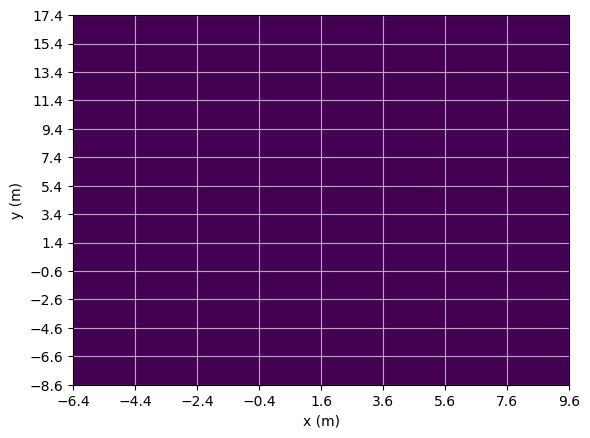

In [83]:
xedges = hippoteach.xedges
yedges = hippoteach.yedges
print(np.rad2deg(hippoteach.aax))
print(hippoteach.Nstates)
Nx = xedges.shape[0]
Ny = yedges.shape[0]

Z = np.zeros((Nx-1, Ny-1))
fig, ax = plt.subplots()
ax.pcolormesh(xedges, yedges, Z.T, shading='auto')
ax.set_xticks(xedges)
ax.set_yticks(yedges)
ax.grid()
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')

fig.savefig(join(plot_dir, 'Arena.png'), dpi=200)

# Bayesian decoder error

In [100]:
# Decoding Errors
import numpy as np
import pandas as pd
from hipposlam.utils import read_pickle
from os.path import join
import matplotlib.pyplot as plt
from pycircstat.descriptive import cdiff, mean as cmean

In [101]:
project_name = 'StateMapLearnerTaughtForest_R5L20_dp2_da8'
project_dir = join('data', project_name)
plot_dir = join('plots', project_name)

BDdf = read_pickle(join(project_dir, 'inferences.pickle'))

xml = BDdf['xML'].to_numpy()
yml = BDdf['yML'].to_numpy()
aml = BDdf['aML'].to_numpy()
xgt = BDdf['xGT'].to_numpy()
ygt = BDdf['yGT'].to_numpy()
agt = BDdf['aGT'].to_numpy()

In [108]:
posdist = np.sqrt(np.square(xml - xgt) + np.square(yml - ygt))
angledist = np.abs(cdiff(aml, agt))
poserr_mdn = np.median(posdist)
angle_mdn = np.median(angledist)

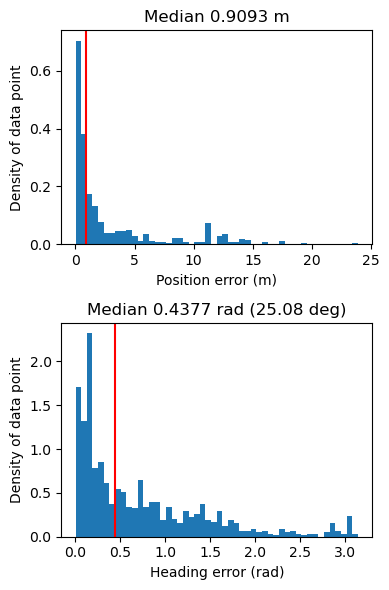

In [191]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))
ax[0].hist(posdist, bins=50, density=True)
ax[0].axvline(poserr_mdn, c='r')
ax[0].set_title(f'Median {poserr_mdn:.4f} m')
ax[0].set_xlabel('Position error (m)')
ax[0].set_ylabel('Density of data point')
ax[1].hist(angledist, bins=50, density=True)
ax[1].axvline(angle_mdn, c='r')
ax[1].set_title(f'Median {angle_mdn:.4f} rad ({np.rad2deg(angle_mdn):.2f} deg)')
ax[1].set_xlabel('Heading error (rad)')

ax[1].set_ylabel('Density of data point')
fig.tight_layout()
fig.savefig(join(plot_dir, 'Decoding error.png'), dpi=300)

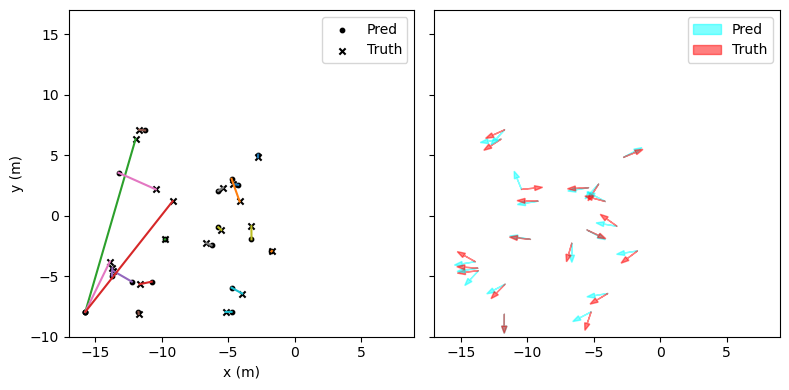

In [192]:
np.random.seed(17)
N = xml.shape[0]
Nsamp = 20

randinds = np.random.choice(N, Nsamp)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
head_width = 0.4
for i, ind in enumerate(randinds):

    ax[0].plot([xml[ind], xgt[ind]], [yml[ind], ygt[ind]])

    label1 = 'Pred' if i == 0 else None
    label2 = 'Truth' if i == 0 else None
    ax[1].arrow(xgt[ind], ygt[ind], np.cos(aml[ind]), np.sin(aml[ind]), color='cyan', head_width=head_width, alpha=0.5, label=label1)
    ax[1].arrow(xgt[ind], ygt[ind], np.cos(agt[ind]), np.sin(agt[ind]), color='r', head_width=head_width, alpha=0.5, label=label2)
ax[0].scatter(xml[randinds], yml[randinds], marker='o', s=10, c='k', label='Pred')
ax[0].scatter(xgt[randinds], ygt[randinds], marker='x', s=20, c='k', label='Truth')

ax[0].legend()
ax[1].legend()
for ac in ax:
    ac.set_xlim(-17, 9)
    ac.set_ylim(-10, 17.)
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
fig.tight_layout()

fig.savefig(join(plot_dir, 'Decoded examples.png'), dpi=200)

# Draw X matrix in video (Paper)

In [5]:
from hipposlam.Sequences import Sequences
import numpy as np
import matplotlib.pyplot as plt
import os
R = 5
L = 20
K = R + L - 1
seq = Sequences(R, L, False)

fids = [[] for _ in range(40)]
fids[0].append('1')
fids[8].append('2')
fids[11].append('3')
fids[14].append('2')
fids[19].append('4')
os.makedirs('Xgif', exist_ok=True)
for i, ids in enumerate(fids):

    seq.step(ids)
    out = seq.X.copy()
    X = np.zeros((4, K))
    X[:len(out), :] = out
    fig, ax = plt.subplots(figsize=(8, 1.8))
    ax.imshow(X)
    # ax.axis('off')
    ax.set_xticks(np.arange(K+1)-0.5, minor=True)
    ax.set_yticks(np.arange(4+1)-0.5, minor=True)
    plt.grid(which='minor')
    ax.set_title(f'X(t={i+1})')
    fig.tight_layout()
    fig.savefig('Xgif/%d.png'%(i), dpi=100)
    plt.close()



# Drawing X for my simulation

In [64]:
# Load data =============================================
debug_plot_tag = False
project_name = 'StateMapLearnerTaughtForest_R5L20_dp2_da8'
project_dir = join('data', project_name)
plot_dir = join('plots', project_name)
os.makedirs(plot_dir, exist_ok=True)
chpt_name = 'PPO$_FullySupervised'
max_chpt_num = 1

# Append traj data and fsigma
trajkeys = 't', 'x', 'y', 'a', 'sid', 'r', 'terminated', 'truncated'
alltrajdict = {key:[] for key in trajkeys}
allfsigmalist = []
for i in range(1, max_chpt_num+1):
    traj_data_pth = join(project_dir, chpt_name.replace('$', '%d'%i) + '_trajdata.pickle')
    trajdict_list = read_pickle(traj_data_pth)  # a list of dictionaries, each for one episode
    for trajdict in trajdict_list:
        # Traj data
        for key in trajkeys:
            alltrajdict[key].extend(trajdict[key])
        # Fsigma
        allfsigmalist.extend(trajdict['fsigma'])
alltrajdf = pd.DataFrame(alltrajdict)

# Load hipposlam
load_hipposlam_pth = join(project_dir, chpt_name.replace('$', '%d'%max_chpt_num) + '_hipposlam.pickle')
hipposlam = read_pickle(load_hipposlam_pth)
hipposeq = hipposlam['hipposeq']
hippomap = hipposlam['hippomap']
hippoteach = hipposlam['hippoteach']
fpos = hipposlam['fpos']
R = hipposeq.R
L = hipposeq.L
F = hipposeq.num_f
K = hipposeq.X_Ncol
stored_f = hipposeq.stored_f
id2fkey_dict = {val:key for key, val in stored_f.items()}

# Assert data validity
assert R == hippomap.R
assert F == hippomap.current_F
assert K == hippomap.K
assert alltrajdf.shape[0] == len(allfsigmalist)

In [65]:
from controllers.hipposlam.hipposlam.Sequences import createX
import collections


In [76]:
inds_c = [val for key, val in stored_f.items() if key[-1]=='c']
inds_f = [val for key, val in stored_f.items() if key[-1]=='f']
inds_t = [val for key, val in stored_f.items() if key[-1]=='t']

inds = inds_f + inds_c + inds_t
sepf = len(inds_f)
sepc = len(inds_c) + sepf

In [95]:
os.makedirs('gif/Xgif_sim', exist_ok=True)
os.makedirs('gif/traj', exist_ok=True)
Xgif_dir = join('gif/Xgif_sim')
traj_dir = join('gif/traj')


# Obtain x, y, a data for each sigma ======================================
xdict = collections.defaultdict(list)
ydict = collections.defaultdict(list)
adict = collections.defaultdict(list)
trange = np.arange(11, 100)  # 11
X = np.zeros((trange.shape[0], F, K))

xmin, xmax = alltrajdf['x'].min(), alltrajdf['x'].max()
ymin, ymax = alltrajdf['y'].min(), alltrajdf['y'].max()
for i, t in enumerate(trange):
    x = alltrajdf['x'][11:t+1]
    y = alltrajdf['y'][11:t+1]

    fig = plt.figure(figsize=(7, 8), facecolor='w')
    ax1 = fig.add_axes([0.05, 0.4, 0.4, 0.35])
    ax2 = fig.add_axes([0.50, 0.05, 0.6, 0.9])
    ax = [ax1, ax2]
    ax[0].plot(x, y, color='r')

    for _, fposeach in fpos.items():
        ax[0].scatter(fposeach[0], fposeach[1], marker='o', color='g')
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)


    fsigma = allfsigmalist[t]
    Xslice = createX(R, F, K, stored_f, fsigma)
    ax[1].imshow(Xslice[inds])
    ax[1].axhline(sepf-0.5, color='r')
    ax[1].axhline(sepc-0.5, color='r')
    ax[1].set_xticks(np.arange(K+1)-0.5, minor=True)
    ax[1].set_yticks(np.arange(F+1)-0.5, minor=True)
    ax[1].grid(which='minor', linewidth=1)
    ax[1].set_title(f'X(t={t})')
    # fig.tight_layout()
    fig.savefig(f'{traj_dir}/{i}.png', dpi=100)
    # break
    plt.close()
